In [95]:
import pandas as pd
import numpy as np

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

import matplotlib.pyplot as plt
from xgboost import plot_importance
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import seaborn as sns

import lightgbm as lgb
import xgboost as xgb

import utils

plt.style.use('ggplot')
%matplotlib inline

In [96]:
def clean_data(data):
    data['error_group'] = 0

    # weight/height correction
    idx = (data['height']<130) & (data['weight']>150)
    data.loc[idx, ["height", "weight"]] = data.loc[idx, ["weight", "height"]].values
#     data.loc[idx, 'error_group'] = 100-1

    # preasure correction
    data.loc[data["ap_hi"] < 0, "ap_hi"] *= -1
    data.loc[data["ap_lo"] < 0, "ap_lo"] *= -1
    
    for i in range(10):
        str_i = str(i)
        data['hi_' + str_i + 's'] = data['ap_hi'].apply(lambda x: str(x).count(str_i))
        data['lo_' + str_i + 's'] = data['ap_lo'].apply(lambda x: str(x).count(str_i))
        for j in range(10):
            str_j = str_i + str(j)
            data['hi_' + str_j + 's'] = data['ap_hi'].apply(lambda x: str(x).count(str_j))
            data['lo_' + str_j + 's'] = data['ap_lo'].apply(lambda x: str(x).count(str_j))
        
    data.loc[(data['ap_lo'] < 20), 'error_group'] = 5
    data.loc[(data['ap_hi'] < 50), 'error_group'] = 6
    data.loc[(data['ap_lo'] > 250), 'error_group'] = 1
    data.loc[(data['ap_lo'] > 4000), 'error_group'] = 2
    data.loc[(data['ap_hi'] > 250), 'error_group'] = 3
    data.loc[(data['ap_hi'] > 10000), 'error_group'] = 4

    data.loc[(data["ap_hi"] < 20) & (data["ap_hi"] > 10), "ap_hi"] *= 10
    data.loc[(data["ap_lo"] < 15) & (data["ap_lo"] > 2), "ap_lo"] *= 10

    idx = data['ap_hi'] > 10000
    data.loc[idx, 'ap_hi'] = 10 * (data.loc[idx, 'ap_hi'] // 1000)
    data.loc[data['ap_lo'] >= 10000, 'ap_lo'] //= 100
    
    manual_update = [
        (12494, ['ap_hi', 'ap_lo'], [120, 80]),
        (42591, ['ap_hi', 'ap_lo'], [140, 90]), # ?
        (78873, ['ap_hi', 'ap_lo'], [130, 100]), # ?
        (51749, ['ap_hi', 'ap_lo'], [120, 80]),
        (57807, ['ap_hi', 'ap_lo'], [170, 100]),
        (60477, ['ap_hi', 'ap_lo'], [110, 80]),
        (91198, ['ap_hi', 'ap_lo'], [100, 90]),
        (6580,  ['ap_hi', 'ap_lo'], [110, 90]),
        (44701, ['ap_hi', 'ap_lo'], [120, 70]),
        (94673,  ['ap_hi', 'ap_lo'], [110, 60]),
        
    ]
    for idx, cols, update in manual_update:
        data.loc[data['id']==idx, cols] = update
    return data

def new_features(data):
    data["BMI"] = 10000 * data["weight"] / (data["height"] * data["height"])
    data["BMI_1"] = 100 * data["weight"] / data["height"]
    data["BMI_3"] = 1000000 * data["weight"] / (data["height"] * data["height"] * data["height"])
    data["BMI_4"] = 100000000 * data["weight"] / (data["height"] * data["height"] * data["height"] * data["height"])
    data["ap_dif"] = data["ap_hi"] - data["ap_lo"]
    data["MAP"] = (data["ap_lo"] * 2 + data["ap_dif"] )/ 3.0
    
    data["age_years"] = np.round(data["age"] / 365)
    
    age_bins = [0, 14000, 14980, 15700, 16420, 17140, 17890, 18625, 19355, 20090, 20820, 21555, 22280, 22990, 24000]
    age_names = list(range(1,len(age_bins)))#[30, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64]
    data["age_group"] = pd.cut(data['age'], age_bins, labels=age_names).astype('float')
    data["age_group_MAPX"] = data["age_group"] * data["MAP"]

    return data

In [97]:
train = pd.read_csv('train.csv', sep=';')
test = pd.read_csv('test.csv', sep=';', na_values='None')

train = clean_data(train)
test = clean_data(test)

train = new_features(train)
test = new_features(test)

X_train = train.drop([ 'cardio'], axis=1)
y_train = train['cardio'].values.ravel()
X_test = test.drop([], axis=1)

# columns_to_interact = ['age_group', 'gender', 'MAP']
# temp = utils.generate_interactions(X_train, columns_to_interact, 2)
# X_train = pd.concat((X_train, temp), axis=1)
# X_test = pd.concat((X_test, utils.generate_interactions(X_test, columns_to_interact, 2)), axis=1)
# print(temp.columns)

# X = pd.concat((X_train, X_test), axis=0)

# from sklearn.preprocessing import LabelEncoder
# from collections import defaultdict
# label_encoder_dict = defaultdict(LabelEncoder)
# columns_to_encode = ['age_group'] + list(temp.columns)


# X[columns_to_encode].apply(lambda x: label_encoder_dict[x.name].fit(x))
# X_train[columns_to_encode] = X_train[columns_to_encode].apply(lambda x: label_encoder_dict[x.name].transform(x))
# X_test[columns_to_encode] = X_test[columns_to_encode].apply(lambda x: label_encoder_dict[x.name].transform(x))

In [98]:
from sklearn.model_selection import train_test_split
__, idx = train_test_split(list(range(X_train.shape[0])), test_size=0.101, random_state=42)
X_train.loc[idx, 'alco'] = np.nan
__, idx = train_test_split(list(range(X_train.shape[0])), test_size=0.101, random_state=43)
X_train.loc[idx, 'smoke'] = np.nan
__, idx = train_test_split(list(range(X_train.shape[0])), test_size=0.096, random_state=44)
X_train.loc[idx, 'active'] = np.nan

from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import scale
from sklearn.model_selection import cross_val_score
from sklearn.base import clone

def impute_nans(model, X_train, X_test, columns, target, perform_cv = False, scoring='accuracy'):
    X = pd.concat((X_train, X_test), axis=0)
    train_idx = ~X[target].isnull()
    model = clone(model)
    model.fit(X.loc[train_idx, columns], X.loc[train_idx, target])
    X_train.loc[X_train[target].isnull(), target] = model.predict(X_train.loc[X_train[target].isnull(), columns])
    X_test.loc[X_test[target].isnull(), target] = model.predict(X_test.loc[X_test[target].isnull(), columns])
    
    if perform_cv:
        n_folds = 7
        kf = StratifiedKFold(random_state=111, n_splits=n_folds, shuffle=True)
        scores = cross_val_score(model, X.loc[train_idx, columns], X.loc[train_idx, target], cv=kf, scoring=scoring)
        print(target, np.mean(scores), 'on', n_folds, 'folds', 'with mean on train', X.loc[train_idx, target].mean())
    
params = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.1,
    'n_estimators': 200,
    'subsample': 0.8,
    'n_jobs': 4,
    'random_state': 2707,
    'silent': True,
}
clf = xgb.XGBClassifier(**params)

columns = ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc','BMI', 'ap_dif', 'MAP']
impute_nans(clf, X_train, X_test, columns, 'smoke')#, perform_cv = True)

columns = ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc','BMI', 'ap_dif', 'MAP', ]
impute_nans(clf, X_train, X_test, columns, 'alco')#, perform_cv = True)

columns = ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc','BMI', 'ap_dif', 'MAP', ]
impute_nans(clf, X_train, X_test, columns, 'active')#, perform_cv = True)

In [99]:
X_train.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke',
       ...
       'lo_99s', 'BMI', 'BMI_1', 'BMI_3', 'BMI_4', 'ap_dif', 'MAP',
       'age_years', 'age_group', 'age_group_MAPX'],
      dtype='object', length=242)

In [110]:
start_columns = [#'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'MAP', 'BMI_3']
"gender",
"height",
"weight",
"ap_hi",
"ap_lo",
"cholesterol",
"gluc",
"smoke",
"alco",
"active",
"error_group",
#     'BMI_1',
    'BMI',
# "BMI_3",
# "BMI_4",
"MAP",
"age_group",
    "ap_dif",
    "lo_14s"
]


start=[]
for sc in start_columns:
    start.append(X_train.columns.get_loc(sc))
start

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 233, 238, 240, 237, 46]

In [111]:
len(X_train.columns)

242

0.00146735		lo_14s
0.00440205		error_group
0.0139398		gender
0.0154072		alco
0.0154072		smoke
0.0198092		active
0.0344828		gluc
0.0528246		ap_lo
0.0682318		cholesterol
0.0755686		ap_dif
0.0843727		MAP
0.0917095		weight
0.0924431		height
0.11372		age_group
0.120323		ap_hi
0.195891		BMI


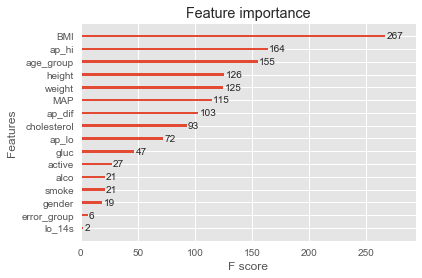

In [112]:
params = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.1,
    'n_estimators': 200,
    'subsample': 0.8,
    'n_jobs': 1,
    'random_state': 2707,
    'silent': True,
}
clf = xgb.XGBClassifier(**params)
clf.fit(X_train[start_columns], y_train)
for a, b in sorted(zip(clf.feature_importances_, X_train[start_columns].columns)):
    print(a,b, sep='\t\t')
plot_importance(clf)
plt.show()

In [ ]:
kf = StratifiedKFold(random_state=12, n_splits=10, shuffle=True)
sfs = SFS(clf, 
           k_features=42, 
           forward=True, 
           floating=True, 
           verbose=2,
           scoring='neg_log_loss',
#            scoring='accuracy',
           n_jobs=1,
           cv=kf)

In [ ]:
sfs = sfs.fit(X_train.values, y_train, start_features=start)


[2017-06-27 16:06:14] Features: 17/42 -- score: -0.538299456162

In [ ]:
pd.DataFrame.from_dict(sfs.get_metric_dict()).T

In [ ]:
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.ylim([-0.52, -0.55])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

In [ ]:
sfs.get_metric_dict()

In [109]:
for i in (2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 233, 237, 238, 46, 240):
    print(X_train.columns[i])

gender
height
weight
ap_hi
ap_lo
cholesterol
gluc
smoke
alco
active
error_group
BMI
ap_dif
MAP
lo_14s
age_group
